In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
from geopy import Point
import warnings

In [3]:

# Load in dataset
df = pd.read_csv("../../../data/finaldatasets/testdata/Treedata1.csv")  # for variogram, etc.


In [ ]:
"""
Enhanced Coordinate Jittering Script for Agricultural Data
Jitters coordinates based on observation density per location-year
WITH COLLISION AVOIDANCE - prevents resampling same coordinates
"""

warnings.filterwarnings('ignore')

def jitter_coordinates_no_overlap(data, 
                                 lat_col='latitude', 
                                 lon_col='longitude',
                                 location_col='location',
                                 year_col='year',
                                 min_radius_km=0.5,     # Base radius (km)
                                 max_radius_km=5.0,     # Maximum radius (km)
                                 scale_factor=0.3,      # How aggressively to scale with n_obs
                                 min_separation_m=100,  # Minimum distance between jittered points
                                 max_attempts=50,       # Maximum attempts to find non-overlapping point
                                 random_seed=123):
    """
    Jitter coordinates with collision avoidance to prevent resampling same locations
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset with coordinates
    lat_col, lon_col : str
        Column names for latitude and longitude
    location_col, year_col : str
        Column names for location and year identifiers
    min_radius_km, max_radius_km : float
        Minimum and maximum jittering radius in kilometers
    scale_factor : float
        Controls how aggressively radius scales with observation count
    min_separation_m : float
        Minimum distance between jittered points within same location-year (meters)
    max_attempts : int
        Maximum attempts to find non-overlapping coordinate before giving up
    random_seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Contains 'data' (jittered dataframe) and 'summary' (summary stats)
    """
    
    np.random.seed(random_seed)
    
    # Check required columns exist
    required_cols = [lat_col, lon_col, location_col, year_col]
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Create a copy to avoid modifying original data
    df = data.copy()
    
    # Create location-year groups and count observations
    df['group_id'] = df[location_col].astype(str) + "_" + df[year_col].astype(str)
    group_counts = df.groupby('group_id').size().reset_index(name='n_obs_per_location_year')
    df = df.merge(group_counts, on='group_id')
    
    # Calculate adaptive radius based on observation count
    df['jitter_radius_km'] = np.minimum(
        max_radius_km,
        min_radius_km + scale_factor * np.log(df['n_obs_per_location_year'])
    )
    
    # Dictionary to store jittered coordinates for each group (for collision detection)
    group_coordinates = {}
    
    # Lists to store results
    jittered_coords = []
    displacements = []
    collision_attempts = []
    
    print("Processing groups with collision avoidance...")
    
    # Process each group separately to avoid coordinate overlap within groups
    for group_id in df['group_id'].unique():
        group_data = df[df['group_id'] == group_id]
        group_jittered_points = []
        
        print(f"Processing {group_id}: {len(group_data)} observations")
        
        for idx, row in group_data.iterrows():
            # Original point
            orig_point = Point(latitude=row[lat_col], longitude=row[lon_col])
            
            # Find a non-overlapping jittered coordinate
            attempts = 0
            found_valid_point = False
            
            while attempts < max_attempts and not found_valid_point:
                attempts += 1
                
                # Generate random distance and bearing
                distance_km = np.random.uniform(0, row['jitter_radius_km'])
                bearing_deg = np.random.uniform(0, 360)
                
                # Calculate new coordinates
                candidate_point = distance(kilometers=distance_km).destination(orig_point, bearing_deg)
                
                # Check if this point is too close to any previously jittered points in this group
                too_close = False
                for existing_point in group_jittered_points:
                    dist_to_existing = distance(candidate_point, existing_point).meters
                    if dist_to_existing < min_separation_m:
                        too_close = True
                        break
                
                if not too_close:
                    # Found a valid point!
                    found_valid_point = True
                    final_point = candidate_point
                    group_jittered_points.append(final_point)
                else:
                    # Too close to existing point, try again
                    continue
            
            # If we couldn't find a non-overlapping point, use the last attempt
            if not found_valid_point:
                print(f"Warning: Could not find non-overlapping point for {group_id} after {max_attempts} attempts")
                final_point = candidate_point
                group_jittered_points.append(final_point)
            
            # Store results
            jittered_coords.append({
                'latitude_jittered': final_point.latitude,
                'longitude_jittered': final_point.longitude
            })
            
            # Calculate actual displacement for QC
            actual_displacement = distance(orig_point, final_point).meters
            displacements.append(actual_displacement)
            collision_attempts.append(attempts)
    
    # Add jittered coordinates to dataframe
    jittered_df = pd.DataFrame(jittered_coords)
    df = pd.concat([df, jittered_df], axis=1)
    df['displacement_m'] = displacements
    df['collision_attempts'] = collision_attempts
    
    # Generate summary statistics
    summary_stats = df.groupby(['group_id', location_col, year_col]).agg({
        'n_obs_per_location_year': 'first',
        'jitter_radius_km': 'first',
        'displacement_m': ['mean', 'max'],
        'collision_attempts': ['mean', 'max']
    }).round(2)
    
    summary_stats.columns = ['n_observations', 'jitter_radius_km', 'mean_displacement_m', 
                           'max_displacement_m', 'mean_attempts', 'max_attempts']
    summary_stats = summary_stats.reset_index()
    
    # Print summary
    print("\nCoordinate Jittering Summary (No Overlap):")
    print("=" * 45)
    print(f"Total observations: {len(df):,}")
    print(f"Unique location-years: {len(summary_stats):,}")
    print(f"Min jitter radius: {df['jitter_radius_km'].min():.2f} km")
    print(f"Max jitter radius: {df['jitter_radius_km'].max():.2f} km")
    print(f"Mean displacement: {df['displacement_m'].mean():.0f} m")
    print(f"Max displacement: {df['displacement_m'].max():.0f} m")
    print(f"Mean collision attempts: {df['collision_attempts'].mean():.1f}")
    print(f"Max collision attempts: {df['collision_attempts'].max()}")
    print(f"Minimum separation enforced: {min_separation_m} m")
    
    # Check for any points that required maximum attempts
    difficult_groups = df[df['collision_attempts'] >= max_attempts]
    if len(difficult_groups) > 0:
        print(f"\nWarning: {len(difficult_groups)} points required maximum attempts")
        print("Consider increasing jitter_radius or decreasing min_separation for these groups:")
        prob_groups = difficult_groups.groupby('group_id')['collision_attempts'].count()
        for group, count in prob_groups.items():
            print(f"  {group}: {count} difficult points")
    
    return {
        'data': df,
        'summary': summary_stats
    }

def check_jittering_quality_enhanced(jittered_data, 
                                   original_lat_col='latitude',
                                   original_lon_col='longitude',
                                   jittered_lat_col='latitude_jittered',
                                   jittered_lon_col='longitude_jittered'):
    """
    Enhanced quality control function with collision avoidance metrics
    """
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Plot 1: Displacement distribution
    axes[0,0].hist(jittered_data['displacement_m']/1000, bins=30, alpha=0.7, color='steelblue')
    axes[0,0].set_title('Distribution of Coordinate Displacements')
    axes[0,0].set_xlabel('Displacement (km)')
    axes[0,0].set_ylabel('Count')
    
    # Plot 2: Jitter radius vs observation count
    axes[0,1].scatter(jittered_data['n_obs_per_location_year'], 
                     jittered_data['jitter_radius_km'], 
                     alpha=0.6, color='darkgreen')
    axes[0,1].set_title('Jitter Radius vs Observation Count')
    axes[0,1].set_xlabel('Observations per Location-Year')
    axes[0,1].set_ylabel('Jitter Radius (km)')
    
    # Plot 3: Collision attempts distribution
    axes[0,2].hist(jittered_data['collision_attempts'], bins=20, alpha=0.7, color='orange')
    axes[0,2].set_title('Distribution of Collision Attempts')
    axes[0,2].set_xlabel('Attempts to Find Valid Point')
    axes[0,2].set_ylabel('Count')
    
    # Plot 4: Original vs Jittered coordinates (sample)
    sample_data = jittered_data.sample(min(1000, len(jittered_data)))
    axes[1,0].scatter(sample_data[original_lon_col], sample_data[original_lat_col], 
                     alpha=0.5, label='Original', s=20, color='red')
    axes[1,0].scatter(sample_data[jittered_lon_col], sample_data[jittered_lat_col], 
                     alpha=0.5, label='Jittered', s=20, color='blue')
    axes[1,0].set_title('Original vs Jittered Coordinates (Sample)')
    axes[1,0].set_xlabel('Longitude')
    axes[1,0].set_ylabel('Latitude')
    axes[1,0].legend()
    
    # Plot 5: Collision attempts vs observation count
    axes[1,1].scatter(jittered_data['n_obs_per_location_year'], 
                     jittered_data['collision_attempts'], 
                     alpha=0.6, color='purple')
    axes[1,1].set_title('Collision Attempts vs Observation Count')
    axes[1,1].set_xlabel('Observations per Location-Year')
    axes[1,1].set_ylabel('Attempts to Find Valid Point')
    
    # Plot 6: Spatial separation within groups (for a sample group)
    # Show jittered points for the group with most observations
    largest_group = jittered_data.loc[jittered_data['n_obs_per_location_year'].idxmax(), 'group_id']
    group_sample = jittered_data[jittered_data['group_id'] == largest_group]
    
    if len(group_sample) > 1:
        axes[1,2].scatter(group_sample[jittered_lon_col], group_sample[jittered_lat_col], 
                         s=50, alpha=0.7, color='green')
        axes[1,2].scatter(group_sample[original_lon_col].iloc[0], group_sample[original_lat_col].iloc[0],
                         s=100, color='red', marker='x', linewidth=3, label='Original')
        axes[1,2].set_title(f'Spatial Separation: {largest_group}')
        axes[1,2].set_xlabel('Longitude')
        axes[1,2].set_ylabel('Latitude')
        axes[1,2].legend()
        
        # Add distance annotations
        for i, row in group_sample.iterrows():
            axes[1,2].annotate(f'{i}', (row[jittered_lon_col], row[jittered_lat_col]), 
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
    else:
        axes[1,2].text(0.5, 0.5, 'No multi-observation groups\nto display', 
                       ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Spatial Separation Example')
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced diagnostic statistics
    diagnostics = {
        'total_obs': len(jittered_data),
        'unique_location_years': jittered_data['group_id'].nunique(),
        'min_displacement_m': jittered_data['displacement_m'].min(),
        'max_displacement_m': jittered_data['displacement_m'].max(),
        'mean_displacement_m': jittered_data['displacement_m'].mean(),
        'median_displacement_m': jittered_data['displacement_m'].median(),
        'coordinates_within_5km': (jittered_data['displacement_m'] <= 5000).sum(),
        'pct_within_5km': (jittered_data['displacement_m'] <= 5000).mean() * 100,
        'mean_collision_attempts': jittered_data['collision_attempts'].mean(),
        'max_collision_attempts': jittered_data['collision_attempts'].max(),
        'points_requiring_max_attempts': (jittered_data['collision_attempts'] >= 50).sum()
    }
    
    print("\nEnhanced Diagnostic Statistics:")
    print("=" * 35)
    for key, value in diagnostics.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value:,}")
    
    return diagnostics

    


Sample dataset created for collision avoidance testing:
Dataset shape: (107, 5)
Observations per location-year:
location  year
Farm_1    2020    14
          2021    23
Farm_2    2020    24
          2021    21
Farm_3    2020    15
          2021    10
dtype: int64
\nThis will test collision avoidance with high-density groups!


Processing groups with collision avoidance...
Processing California_2010: 5 observations
Processing California_2011: 5 observations
Processing Glyndon, MN_2015: 7 observations
Processing Glyndon, MN_2014: 7 observations
Processing Heibei, China_2015: 4 observations
Processing Heibei, China_2016: 4 observations
Processing Heibei, China_2017: 4 observations
Processing Heibei, China_2018: 4 observations
Processing Yisheng, China_2018: 5 observations
Processing Yisheng, China_2019: 5 observations
Processing Mengcheng County, China_2014: 6 observations
Processing Mengcheng County, China_2015: 6 observations
Processing Yingling China_2015: 4 observations
Processing Changshu, China_2012: 14 observations
Processing Suzhou, China_2012: 5 observations
Processing New Delhi_2013: 6 observations
Processing New Delhi_2014: 6 observations
Processing Wuxue City, China_2012: 4 observations
Processing Huantai County, China_2009: 8 observations
Processing Huantai County, China_2010: 8 observations
Proces

KeyError: 'displacement_m'

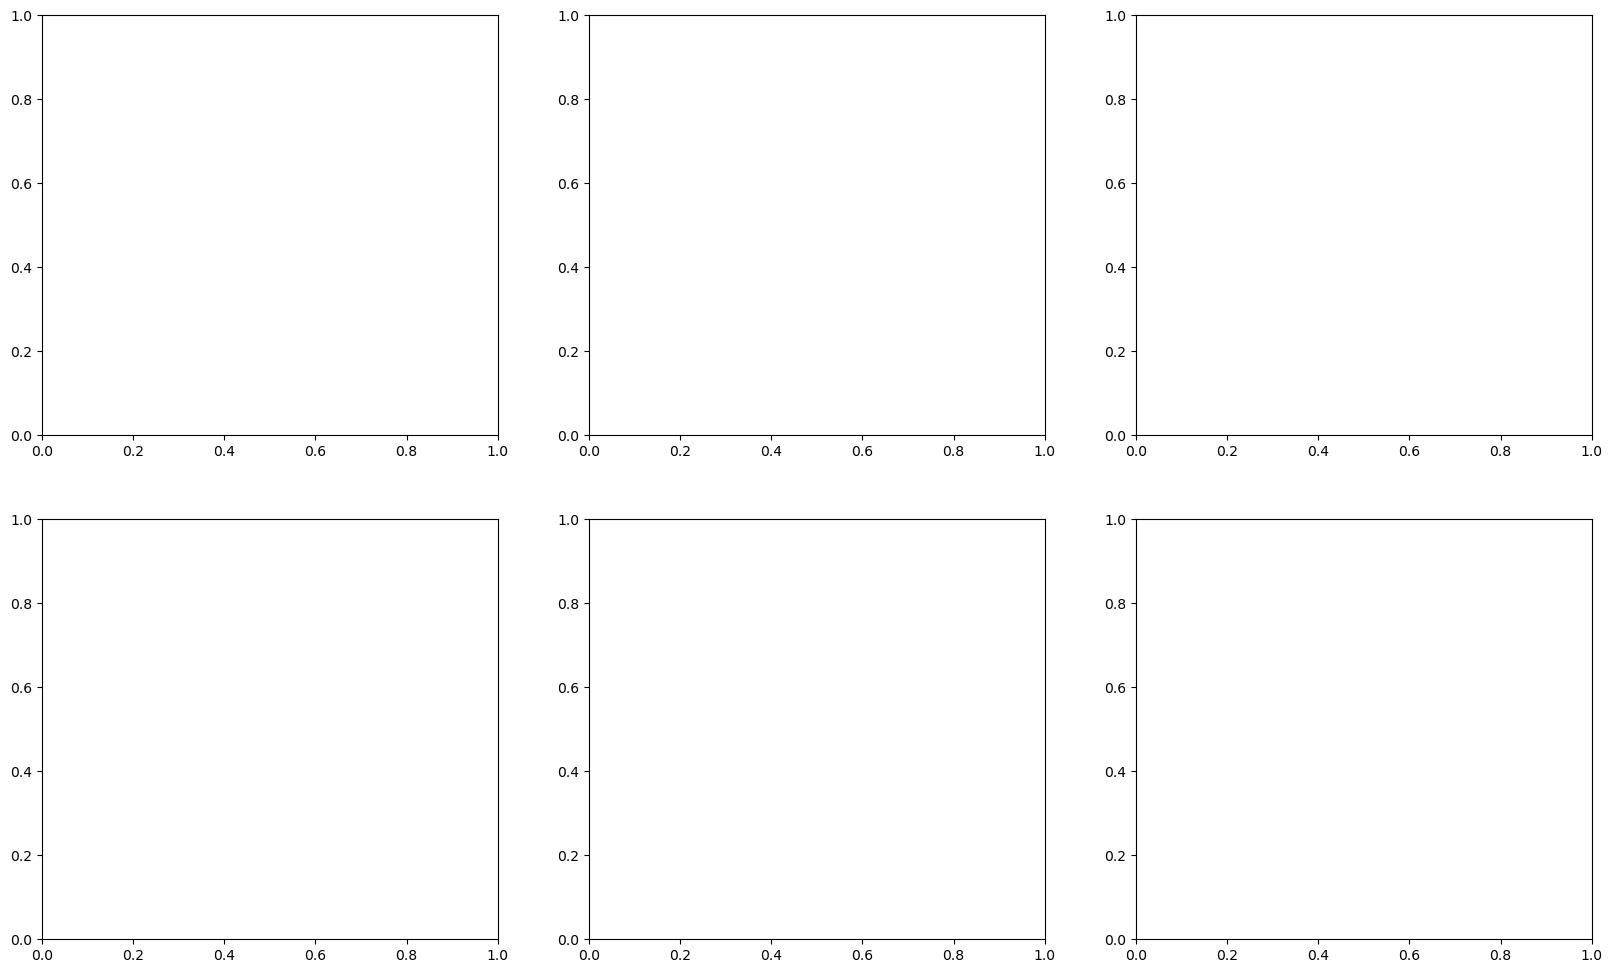

In [8]:
result = jitter_coordinates_no_overlap(data = df, 
                                 lat_col='Conversion.for.latitude', 
                                 lon_col='Conversion.for.longitude',
                                 location_col='Location',
                                 year_col='year',
                                 min_radius_km=0.5,     # Base radius (km)
                                 max_radius_km=10.0,     # Maximum radius (km)
                                 scale_factor=0.7,      # How aggressively to scale with n_obs
                                 min_separation_m=50,  # Minimum distance between jittered points
                                 max_attempts=5,       # Maximum attempts to find non-overlapping point
                                 random_seed=123)

check_jittering_quality_enhanced(result)

In [11]:
#file preprocessing
result['data'].drop(columns=['collision_attempts', 'displacement_m', 'n_obs_per_location_year','Unnamed:_0.1', 'Unnamed:_0'], inplace=True)

In [13]:
result['data'].to_csv("../../../data/finaldatasets/testdata/jittered_treedata.csv", index=False)